# Bank Classification Project - Preprocessing

In [13]:
# Imports
%matplotlib inline

import timeit

import pandas as pd
import numpy as np
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, RandomizedPCA, KernelPCA

In [14]:
bank_data = pd.read_csv('data/bank-additional/bank-additional-full.csv', 
                        sep=';', na_values=['NA'])

## Preprocessing

In [15]:
# Change yes/no to binary
bank_data = bank_data.replace(['yes', 'no'], [1, 0])

In [16]:
# Move y to front for readability
cols = bank_data.columns.tolist()
cols = cols[-1:] + cols[:-1]
bank_data = bank_data[cols]

In [17]:
# Replace 'unknown' with NAN 
# Use an imputation strategy
bank_data.replace(['unknown'], [np.nan], inplace=True)
bank_data['pdays'].replace([999], [np.nan], inplace=True)
bank_data = bank_data.fillna(bank_data.median())

In [18]:
# Get dummy variables for categorical features    
columns = ['job', 'marital', 'education', 'contact', 'month', 'day_of_week', 'poutcome']    
bank_data = pd.get_dummies(bank_data, columns=columns)

In [19]:
pickle.dump(bank_data, open('data/bank_data.pkl', 'wb'))

In [20]:
bank_data.head()

,y,age,default,housing,loan,duration,campaign,pdays,previous,emp.var.rate,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,56,0.0,0.0,0.0,261,1,6.0,0,1.1,...,0,0,0,1,0,0,0,0,1,0
1,0,57,0.0,0.0,0.0,149,1,6.0,0,1.1,...,0,0,0,1,0,0,0,0,1,0
2,0,37,0.0,1.0,0.0,226,1,6.0,0,1.1,...,0,0,0,1,0,0,0,0,1,0
3,0,40,0.0,0.0,0.0,151,1,6.0,0,1.1,...,0,0,0,1,0,0,0,0,1,0
4,0,56,0.0,0.0,1.0,307,1,6.0,0,1.1,...,0,0,0,1,0,0,0,0,1,0


In [21]:
# Train test split
X, y = bank_data.iloc[:, 1:].values, bank_data.iloc[:, 0].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

 1) duration                       0.298209
 2) euribor3m                      0.094987
 3) age                            0.085736
 4) nr.employed                    0.052321
 5) campaign                       0.042234
 6) poutcome_success               0.027928
 7) cons.conf.idx                  0.026417
 8) emp.var.rate                   0.025405
 9) cons.price.idx                 0.023264
10) housing                        0.020080
11) pdays                          0.013880
12) loan                           0.013256
13) previous                       0.012972
14) education_university.degree    0.012469
15) job_admin.                     0.012281
16) marital_married                0.011915
17) education_high.school          0.011297
18) day_of_week_mon                0.011111
19) day_of_week_thu                0.010997
20) marital_single                 0.010817
21) day_of_week_tue                0.010721
22) day_of_week_wed                0.010698
23) day_of_week_fri             

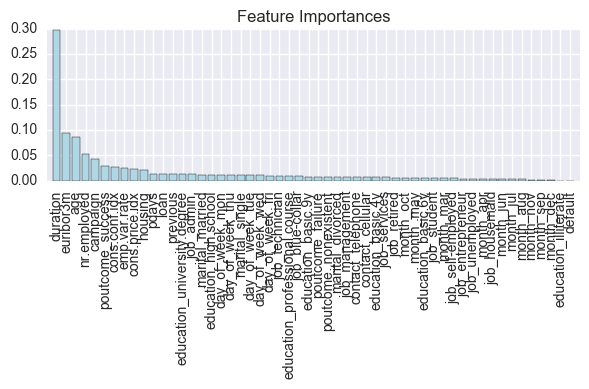

In [22]:
# Feature importance with Random Forests
feat_labels = bank_data.columns[1:]

forest = RandomForestClassifier(n_estimators=1000,
                                random_state=0,
                                n_jobs=-1)

forest.fit(X, y)
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))

plt.title('Feature Importances')
plt.bar(range(X.shape[1]), 
        importances[indices],
        color='lightblue', 
        align='center')

plt.xticks(range(X.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
# plt.savefig('./images/random_forest.png', dpi=300)
plt.show()

## Dimensionality Reduction

In [23]:
# Extracting only the continuous variables, binary ones will not help
continuous = bank_data[['age', 'duration', 'campaign', 'pdays', 'previous', 
                        'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 
                        'nr.employed']]

In [24]:
# Bringing features on the same scale
stdsc = StandardScaler()
continuous_std = stdsc.fit_transform(continuous)

### Linear methods

In [25]:
pca = PCA(n_components=10)
%timeit continuous_pca = pca.fit_transform(continuous_std)

The slowest run took 13.58 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 15.3 ms per loop


In [26]:
rpca = RandomizedPCA(10)
%timeit rpca.fit_transform(continuous_std)

/Users/osx10/anaconda/lib/python3.5/site-packages/sklearn/utils/deprecation.py:52: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


10 loops, best of 3: 91 ms per loop


In [27]:
# Randomized PCA has been deprecated, use original class
rpca = PCA(n_components=10, svd_solver='randomized')
%timeit continuous_rpca = rpca.fit_transform(continuous_std)

10 loops, best of 3: 113 ms per loop


In [66]:
pca = PCA(n_components=3)
continuous_pca = pca.fit_transform(continuous_std)

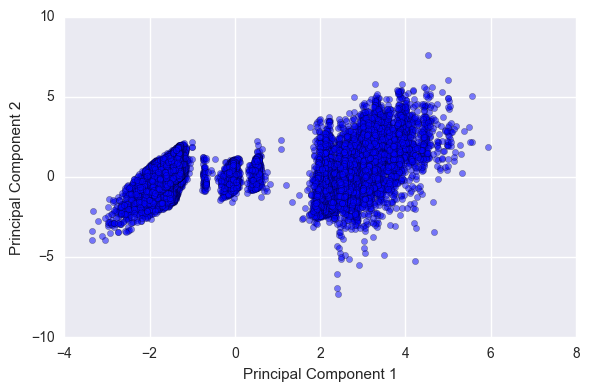

In [84]:
plt.scatter(continuous_pca[:, 0], continuous_pca[:, 1], c="Blue", alpha=.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [ ]:
yes = [idx for idx, x in enumerate(y) if x == 1]
no = [idx for idx, x in enumerate(y) if x == 0]

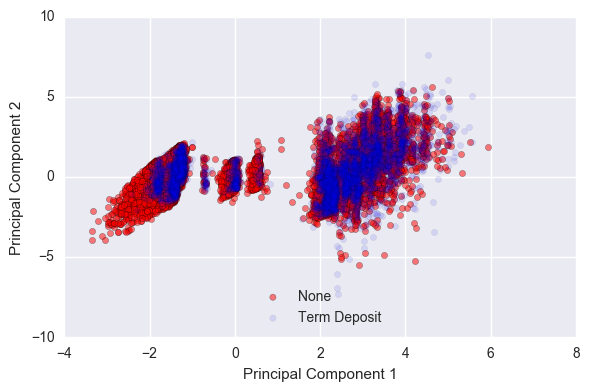

In [90]:
plt.scatter(continuous_pca[no, 0], continuous_pca[no, 1], label="None", 
            c="Red", alpha=0.5)
plt.scatter(continuous_pca[yes, 0], continuous_pca[yes, 1], label="Term Deposit",
            c="Blue", alpha=0.1)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

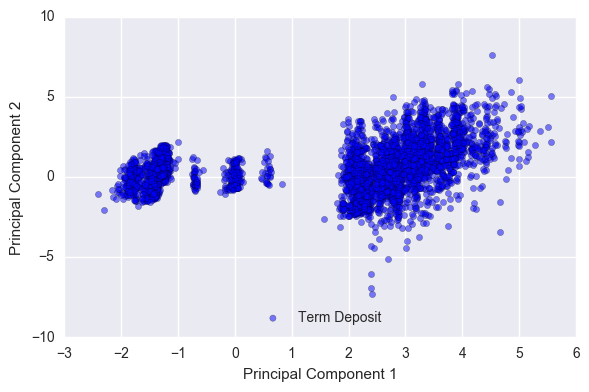

In [81]:
plt.scatter(continuous_pca[yes, 0], continuous_pca[yes, 1], label="Term Deposit",
            c="Blue", alpha=.5)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

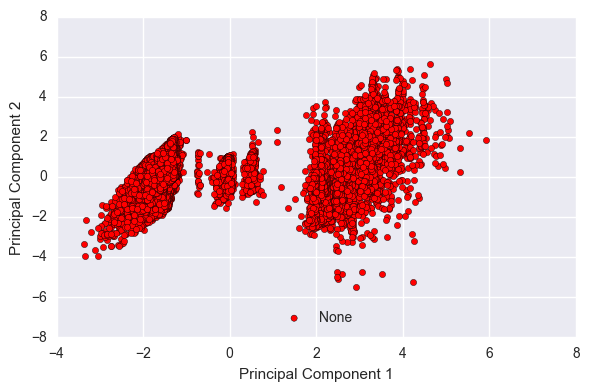

In [80]:
plt.scatter(continuous_pca[no, 0], continuous_pca[no, 1], label="None", 
            c="Red", alpha=1.0)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(loc='lower center')
plt.tight_layout()
plt.show()

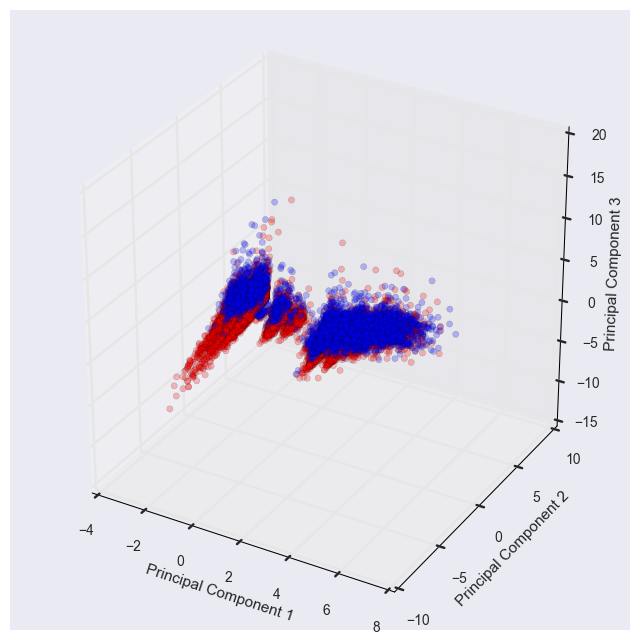

In [71]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(continuous_pca[no, 0], continuous_pca[no, 1], continuous_pca[no, 2], 
            label="None", c="Red", alpha=0.25)
ax.scatter(continuous_pca[yes, 0], continuous_pca[yes, 1], continuous_pca[yes, 2],
            label="Term Deposit", c="Blue", alpha=0.25)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

In [29]:
var_exp = pca.explained_variance_ratio_
cum_var_exp = np.cumsum(var_exp)

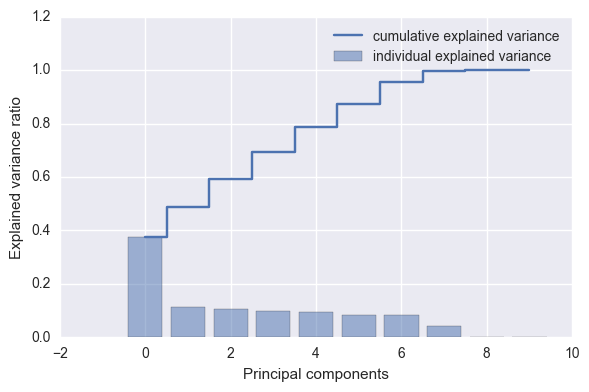

In [30]:
plt.figure(figsize=(6, 4))
plt.bar(range(10), var_exp, alpha=0.5, align='center',
        label='individual explained variance')
plt.step(range(10), cum_var_exp, where='mid',
         label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

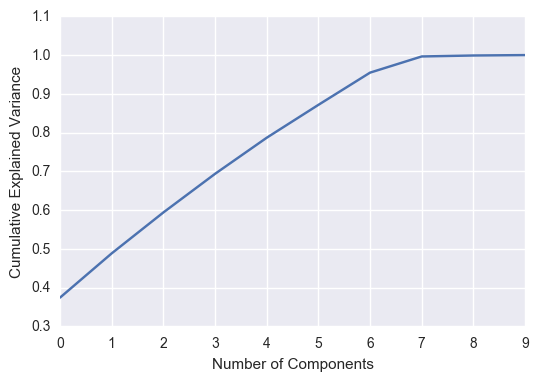

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

PCA is not able to explain much variance. Rather not use principal components in the pipeline and stick to the regular variables. Other non-linear dimensionality reduction techniques could prove useful to explore.